# Imports

In [1]:
import os
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# File Processing

In [2]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(f"Processing file: {filepath}")


Processing file: ./dataset\fhvhv_tripdata_2022-01.parquet
Processing file: ./dataset\fhvhv_tripdata_2022-02.parquet


# Loading Data & Data Verification

In [3]:
path_files = []

for year in range(2022, 2025):
    year_files = [files for files in os.listdir('./dataset') if f'_{year}-' in files]
    year_files.sort() 
    
    for file in year_files:
        path_files.append(pandas.read_parquet('./dataset/' + file))
        
print(f"Loaded {len(path_files)} files.")

Loaded 2 files.


In [4]:
df = pandas.concat(path_files, ignore_index=True)
print(f"Total rows: {len(df)}")

Total rows: 30770874


In [5]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [6]:
df['base_passenger_fare'].describe()

count    3.077087e+07
mean     2.041490e+01
std      1.598893e+01
min     -5.201100e+02
25%      1.029000e+01
50%      1.609000e+01
75%      2.502000e+01
max      4.995960e+03
Name: base_passenger_fare, dtype: float64

# Data Cleaning

In [7]:
df = df[(df['base_passenger_fare'] >= 0) & (df['base_passenger_fare'] < 100)]
print(f"Rows after filtering by fare: {len(df)}")

Rows after filtering by fare: 30589303


In [8]:
df = df[df['airport_fee'] == 0]
print(f"Rows after removing airport fee: {len(df)}")

Rows after removing airport fee: 28799598


In [9]:
df = df[['hvfhs_license_num', 'request_datetime','trip_miles','trip_time', 'base_passenger_fare', 'tips']]
df.describe()

,request_datetime,trip_miles,trip_time,base_passenger_fare,tips
count,28799598,2.879960e+07,2.879960e+07,2.879960e+07,2.879960e+07
mean,2022-02-01 05:06:40.889685,4.022582e+00,1.000048e+03,1.859486e+01,7.175391e-01
min,2021-12-31 22:55:05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022-01-17 19:52:30,1.480000e+00,5.480000e+02,9.970000e+00,0.000000e+00
50%,2022-02-02 08:48:51,2.633000e+00,8.450000e+02,1.537000e+01,0.000000e+00
75%,2022-02-15 14:59:04,5.045000e+00,1.279000e+03,2.323000e+01,0.000000e+00
max,2022-03-01 00:10:00,3.611130e+02,9.915200e+04,9.999000e+01,2.000000e+02
std,NaN,4.030963e+00,6.415795e+02,1.176026e+01,2.048696e+00


# Feature Engineering

In [10]:
df['request_hour'] = df['request_datetime'].dt.hour
df['request_day_of_week'] = df['request_datetime'].dt.dayofweek

In [11]:
encoder = LabelEncoder()
df['hvfhs_license_num_encoded'] = encoder.fit_transform(df['hvfhs_license_num'])
df = df.drop(columns=['hvfhs_license_num'])

# Feature Correlation Heatmap

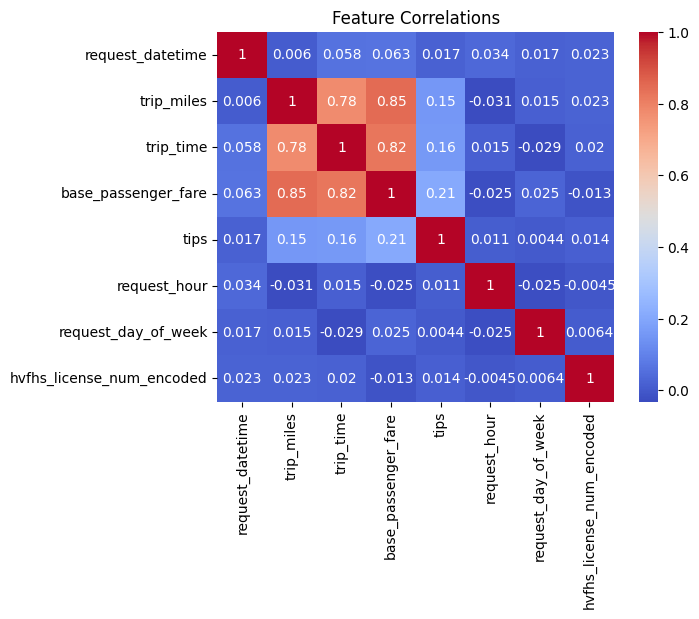

In [12]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# Spliting Data (Train, Validation, Test)

In [13]:
# Train: Days 1–20
train_data = df[df['request_datetime'].dt.day <= 20]

# Validation: Days 21–25
validation_data = df[(df['request_datetime'].dt.day >= 21) & (df['request_datetime'].dt.day <= 25)]

# Test: Days 26–end of the month
test_data = df[df['request_datetime'].dt.day >= 26]

In [14]:
train_data = train_data.drop(columns=['request_datetime'])
validation_data = validation_data.drop(columns=['request_datetime'])
test_data = test_data.drop(columns=['request_datetime'])

# Data Normalization

In [15]:
columns_to_scale = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']

scaler = StandardScaler()

# Training data
train_data_scaled = train_data.copy()
train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Validation data
validation_data_scaled = validation_data.copy()
validation_data_scaled[columns_to_scale] = scaler.transform(validation_data[columns_to_scale])

# Test data
test_data_scaled = test_data.copy()
test_data_scaled[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

In [16]:
print("Train Data Sample:")
train_data[:10]

Train Data Sample:


,trip_miles,trip_time,base_passenger_fare,tips,request_hour,request_day_of_week,hvfhs_license_num_encoded
0,1.18,664,24.90,0.0,0,5,0
1,0.82,460,11.97,0.0,0,5,0
2,1.18,595,29.82,0.0,0,5,0
3,1.65,303,7.91,0.0,0,5,0
4,1.65,461,9.44,0.0,0,5,0
5,4.51,762,17.67,0.0,0,5,0
6,3.68,931,16.68,0.0,0,5,0
7,2.77,843,14.41,4.0,0,5,0
8,2.04,710,10.64,0.0,0,5,0
10,11.29,1387,34.90,0.0,0,5,0


In [17]:
print("Validation Data Sample:")
validation_data[:10]

Validation Data Sample:


,trip_miles,trip_time,base_passenger_fare,tips,request_hour,request_day_of_week,hvfhs_license_num_encoded
9149683,4.460,760,17.93,0.0,0,4,0
9149807,2.380,611,12.08,0.0,0,4,0
9150931,14.470,2193,43.78,0.0,0,4,0
9154127,1.380,583,8.95,0.0,0,4,0
9154380,9.470,995,27.70,0.0,0,4,0
9157991,10.270,1532,28.35,0.0,0,4,0
9159006,4.740,1239,21.75,0.0,0,4,0
9161684,0.890,389,8.41,0.0,0,4,0
9164521,19.640,1777,50.04,0.0,0,4,0
9165178,5.846,1242,23.88,0.0,0,4,1


In [18]:
df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']] = scaler.fit_transform(
    df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']]
)

# Prepare Data for Hyperparameter Tuning

In [19]:
def prepare_data(target_column):
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]

    X_val = validation_data.drop(columns=[target_column])
    y_val = validation_data[target_column]

    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Neural Network Model with Hyperparameter Optimization

In [20]:
def build_model(neurons, optimizer, dropout_rate):
    model = Sequential()
    for n in neurons:
        model.add(Dense(n, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def custom_grid_search(X_train, y_train, param_grid, cv=3):
    best_params = None
    best_score = float('inf')

    for neurons in param_grid['neurons']:
        for optimizer in param_grid['optimizer']:
            for dropout_rate in param_grid['dropout_rate']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        print(f"Training with: neurons={neurons}, optimizer={optimizer.__class__.__name__}, dropout_rate={dropout_rate}, "
                              f"batch_size={batch_size}, epochs={epochs}")
                        
                        optimizer_instance = optimizer.__class__()

                        model = build_model(neurons=neurons, optimizer=optimizer_instance, dropout_rate=dropout_rate)
                        history = model.fit(
                            X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            validation_split=1/cv,
                            callbacks=[early_stopping],
                        )
                        
                        # Evaluate with validation loss
                        val_loss = history.history['val_loss'][-1]
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'neurons': neurons,
                                'optimizer': optimizer.__class__.__name__,
                                'dropout_rate': dropout_rate,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }

    print("Best Parameters:", str(best_params))
    return best_params

# Train and Evaluate Model

In [22]:
def train_and_evaluate(target_column, neurons, optimizer, dropout_rate, batch_size, epochs):
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(target_column)
    model = build_model(neurons=neurons, optimizer=optimizer, dropout_rate=dropout_rate)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])
    y_pred = model.predict(X_test)

    mse = numpy.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Target: {target_column} | MSE: {mse:.2f} | MAE: {mae:.2f}")

    return model, history

# Plot Training History

In [23]:
def plot_training_history(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{name} Model Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Base Passenger Fare Model

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data('base_passenger_fare')

In [25]:
param_grid = {
    'neurons': [(128, 64, 32)],
    'optimizer': [Adam(), RMSprop()],
    'dropout_rate': [0.3],
    'batch_size': [32],
    'epochs': [5]
}

best_params = custom_grid_search(X_train, y_train, param_grid)

Training with: neurons=(128, 64, 32), optimizer=Adam, dropout_rate=0.3, batch_size=32, epochs=5
Training with: neurons=(128, 64, 32), optimizer=RMSprop, dropout_rate=0.3, batch_size=32, epochs=5
Best Parameters: {'neurons': (128, 64, 32), 'optimizer': 'RMSprop', 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 5}


In [26]:
base_model, base_history = train_and_evaluate(
    target_column='base_passenger_fare',
    neurons=best_params['neurons'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    batch_size=best_params['batch_size'],
    epochs=20
)

Epoch 1/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 986s 2ms/step - loss: 37.8866 - mae: 3.6881 - val_loss: 55.9547 - val_mae: 4.4199
Epoch 2/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 983s 2ms/step - loss: 34.3787 - mae: 3.6406 - val_loss: 50.7300 - val_mae: 4.2201
Epoch 3/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1048s 2ms/step - loss: 34.8581 - mae: 3.6751 - val_loss: 36.0494 - val_mae: 3.4964
Epoch 4/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 985s 2ms/step - loss: 35.2704 - mae: 3.6974 - val_loss: 41.7358 - val_mae: 3.8917
Epoch 5/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 979s 2ms/step - loss: 35.6765 - mae: 3.7234 - val_loss: 46.9632 - val_mae: 4.0078
Epoch 6/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1092s 2ms/step - loss: 35.8123 - mae: 3.7386 - val_loss: 48.8038 - val_mae: 4.0371
Epoch 7/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1165s 2ms/step - loss: 35.9023 - mae: 3.7511 - val_loss: 36.2439 - val_mae: 3.6109
Epoch 8/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1148s 2ms/step - loss: 36.3856 - mae: 3.7812 - val_loss

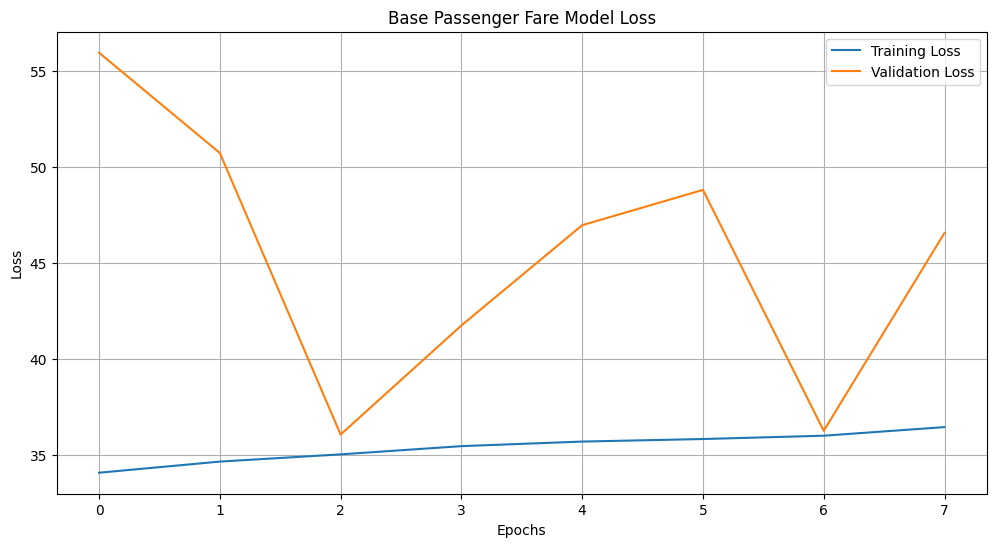

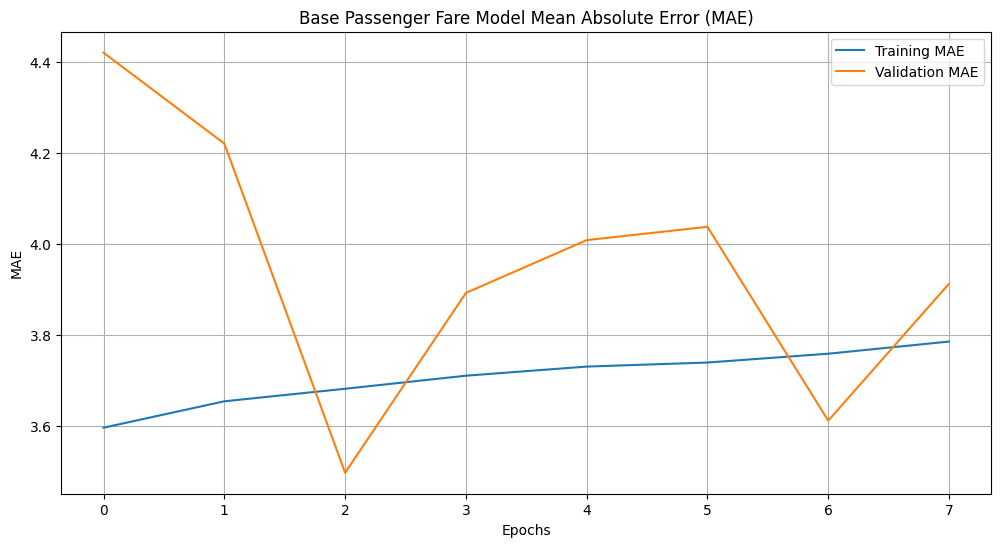

In [27]:
plot_training_history(base_history, 'Base Passenger Fare')

# Compare Fare Predictions For Uber/Lyft

101102/101102 ━━━━━━━━━━━━━━━━━━━━ 90s 886us/step
Uber - MSE: 10.35, MAE: 10.19


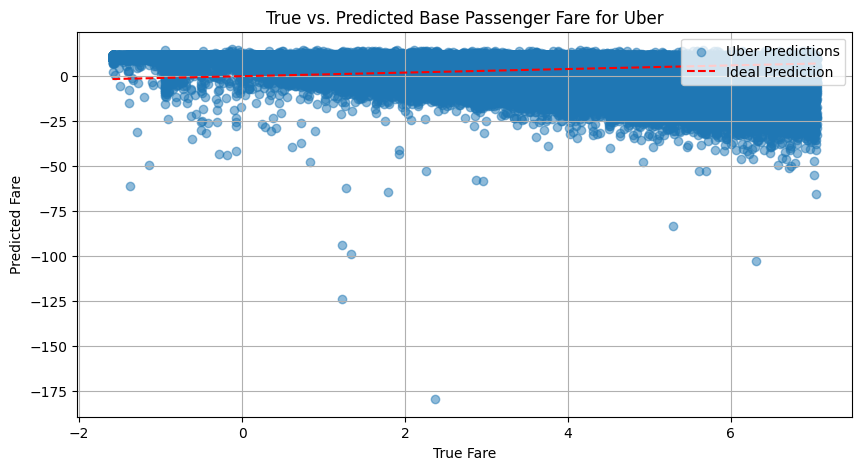

38777/38777 ━━━━━━━━━━━━━━━━━━━━ 34s 884us/step
Lyft - MSE: 10.17, MAE: 10.01


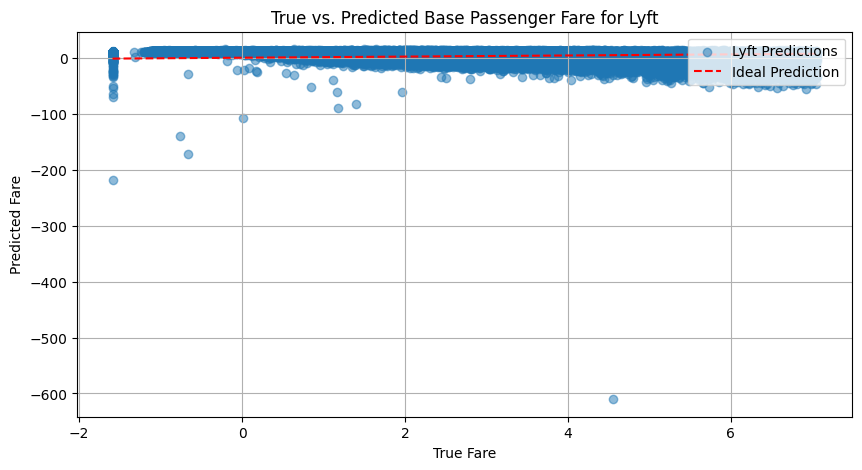

In [28]:
license_plates = {'HV0003': 'Uber', 'HV0005': 'Lyft'}
license_plates_encoded = {encoder.transform([plate])[0]: company for plate, company in license_plates.items()}
target_column = 'base_passenger_fare'

for encoded_plate, company in license_plates_encoded.items():
    group_data = test_data_scaled[test_data_scaled['hvfhs_license_num_encoded'] == encoded_plate]
    
    X_group = group_data.drop(columns=[target_column])
    y_group_true = group_data[target_column]
    
    y_group_pred = base_model.predict(X_group)
    
    group_mse = numpy.sqrt(mean_squared_error(y_group_true, y_group_pred))
    group_mae = mean_absolute_error(y_group_true, y_group_pred)
    
    print(f"{company} - MSE: {group_mse:.2f}, MAE: {group_mae:.2f}")
    
    # Plot true vs. predicted fares
    plt.figure(figsize=(10, 5))
    plt.scatter(y_group_true, y_group_pred, alpha=0.5, label=f"{company} Predictions")
    plt.plot([y_group_true.min(), y_group_true.max()], [y_group_true.min(), y_group_true.max()], 'r--', label='Ideal Prediction')
    plt.title(f"True vs. Predicted Base Passenger Fare for {company}")
    plt.xlabel('True Fare')
    plt.ylabel('Predicted Fare')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Evaluate Accuracy by Hour

In [29]:
test_data_scaled['request_hour'] = test_data['request_hour']

# Group by hour and compute average MSE
hourly_mse = test_data_scaled.groupby('request_hour', group_keys=False).apply(
    lambda group: numpy.sqrt(mean_squared_error(group[target_column], base_model.predict(group.drop(columns=[target_column]))))
)

5570/5570 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 4s 908us/step
3080/3080 ━━━━━━━━━━━━━━━━━━━━ 3s 888us/step
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step
5566/5566 ━━━━━━━━━━━━━━━━━━━━ 5s 902us/step
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 6s 904us/step
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 5s 899us/step
5684/5684 ━━━━━━━━━━━━━━━━━━━━ 5s 888us/step
5759/5759 ━━━━━━━━━━━━━━━━━━━━ 5s 890us/step
5903/5903 ━━━━━━━━━━━━━━━━━━━━ 5s 900us/step
6209/6209 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step
6865/6865 ━━━━━━━━━━━━━━━━━━━━ 6s 918us/step
7008/7008 ━━━━━━━━━━━━━━━━━━━━ 6s 899us/step
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 6s 871us/step
8151/8151 ━━━━━━━━━━━━━━━━━━━━ 7s 898us/step
8941/8941 ━━━━━━━━━━━━━━━━━━━━ 8s 867us/step
8729/8729 ━━━━━━━━━━━━━━━━━━━━ 8s 882us/step
7871/7871 ━━━━━━━━━━━━━━━━━━━━ 7s 877us/step
7483/7483 ━━━━━━━━━━━━━━━━━━━━ 7s 895us/step
7402/7402 

C:\Users\Anshi Singh\AppData\Local\Temp\ipykernel_42788\565686546.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_mse = test_data_scaled.groupby('request_hour', group_keys=False).apply(


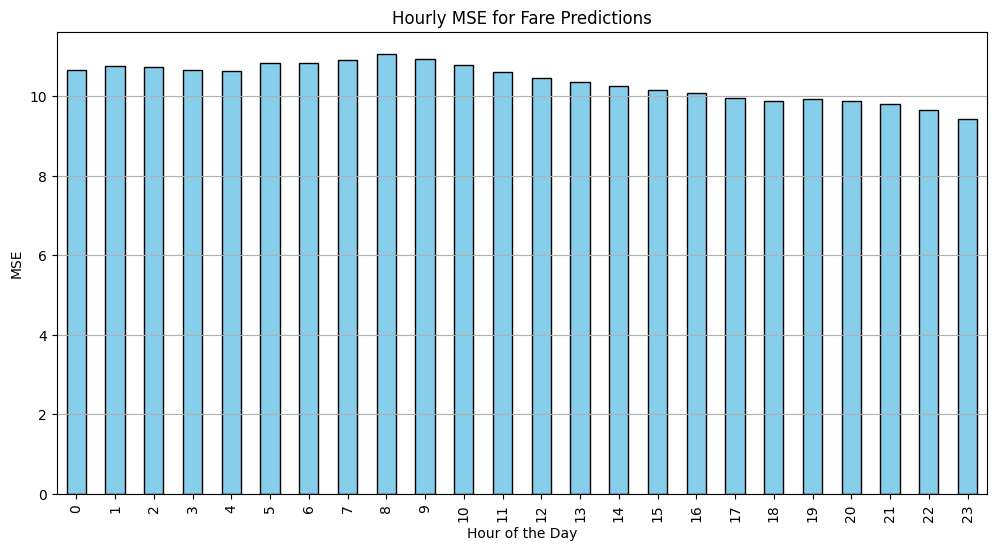

In [30]:
# Plot hourly MSE
plt.figure(figsize=(12, 6))
hourly_mse.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Hourly MSE for Fare Predictions')
plt.xlabel('Hour of the Day')
plt.ylabel('MSE')
plt.grid(axis='y')
plt.show()

# Tips Model

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data('tips')

In [32]:
param_grid = {
    'neurons': [(128, 64, 32)],
    'optimizer': [Adam(), RMSprop()],
    'dropout_rate': [0.3],
    'batch_size': [32],
    'epochs': [5]
}

best_params = custom_grid_search(X_train, y_train, param_grid)

Training with: neurons=(128, 64, 32), optimizer=Adam, dropout_rate=0.3, batch_size=32, epochs=5
Training with: neurons=(128, 64, 32), optimizer=RMSprop, dropout_rate=0.3, batch_size=32, epochs=5
Best Parameters: {'neurons': (128, 64, 32), 'optimizer': 'RMSprop', 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 5}


In [33]:
tips_model, tips_history = train_and_evaluate(
    target_column='tips',
    neurons=best_params['neurons'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    batch_size=best_params['batch_size'],
    epochs=20
)

Epoch 1/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1019s 2ms/step - loss: 9.3548 - mae: 1.2178 - val_loss: 3.9827 - val_mae: 1.1671
Epoch 2/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1020s 2ms/step - loss: 4.0262 - mae: 1.1715 - val_loss: 3.9984 - val_mae: 1.2172
Epoch 3/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1020s 2ms/step - loss: 4.0349 - mae: 1.1696 - val_loss: 3.9710 - val_mae: 1.1030
Epoch 4/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1030s 2ms/step - loss: 4.0416 - mae: 1.1710 - val_loss: 3.9748 - val_mae: 1.1456
Epoch 5/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1242s 2ms/step - loss: 4.0351 - mae: 1.1705 - val_loss: 3.9824 - val_mae: 1.1145
Epoch 6/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1162s 2ms/step - loss: 4.0293 - mae: 1.1698 - val_loss: 4.0171 - val_mae: 1.2134
Epoch 7/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1152s 2ms/step - loss: 4.0436 - mae: 1.1716 - val_loss: 3.9756 - val_mae: 1.1406
Epoch 8/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1160s 2ms/step - loss: 4.0410 - mae: 1.1709 - val_loss: 4.0159 - 

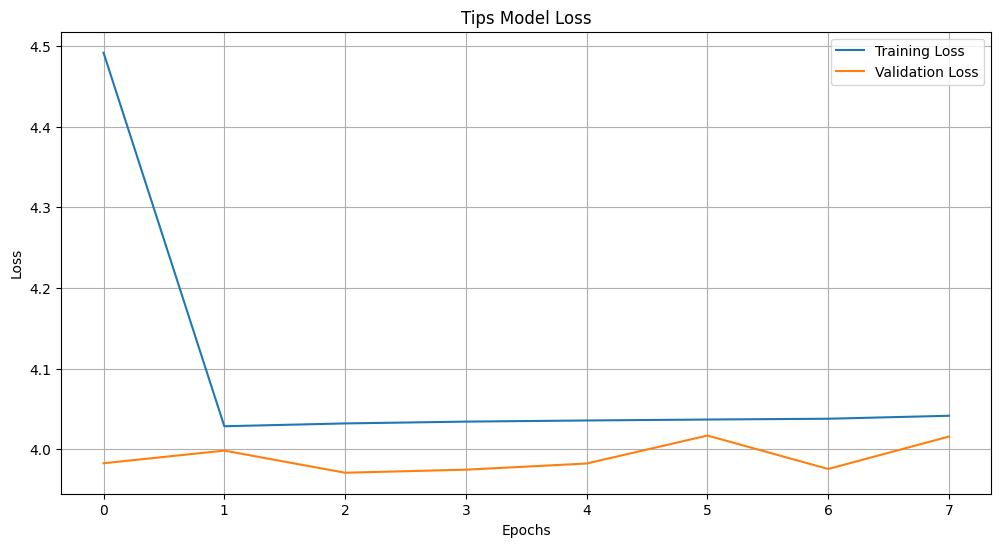

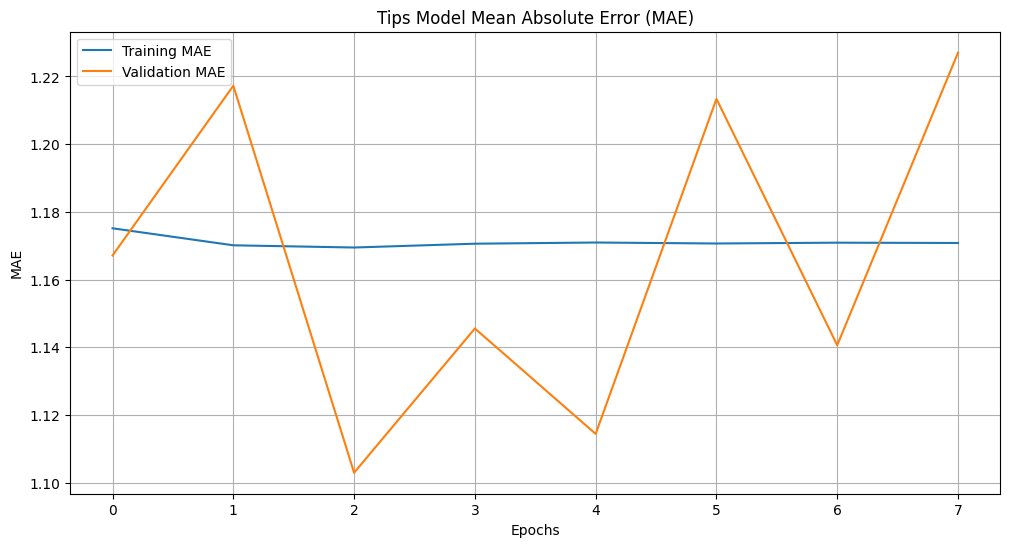

In [34]:
plot_training_history(tips_history, 'Tips')

139878/139878 ━━━━━━━━━━━━━━━━━━━━ 148s 1ms/step
Overall - MSE: 1.12, MAE: 0.68


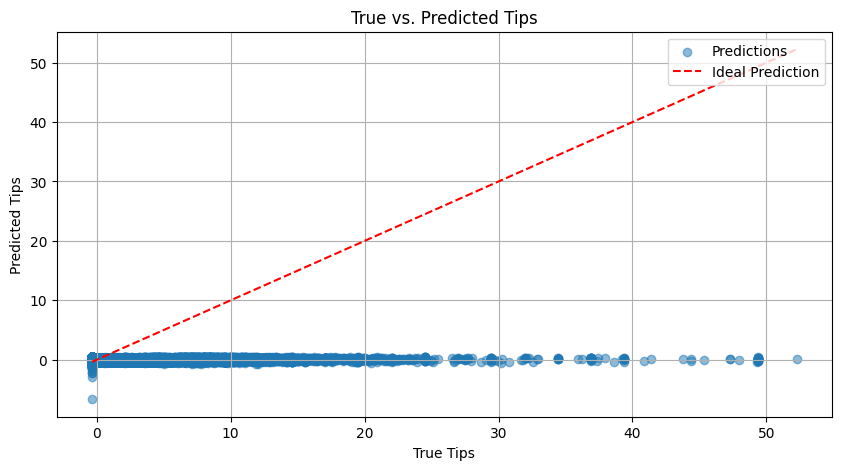

In [35]:
target_column = 'tips'

X_test = test_data_scaled.drop(columns=[target_column])
y_test = test_data_scaled[target_column]

y_pred = tips_model.predict(X_test)

overall_mse = numpy.sqrt(mean_squared_error(y_test, y_pred))
overall_mae = mean_absolute_error(y_test, y_pred)

print(f"Overall - MSE: {overall_mse:.2f}, MAE: {overall_mae:.2f}")

# Plot true vs. predicted tips
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')
plt.title("True vs. Predicted Tips")
plt.xlabel('True Tips')
plt.ylabel('Predicted Tips')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()